In [1]:
import torch
from torch import nn

# Import PyTorch
import torch
from torch import nn

## Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

import pandas as pd
import numpy as np

import os
from tqdm.auto import tqdm
from pathlib import Path

from PIL import Image
# from torchinfo import summary


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
vgg_model = torchvision.models.vgg11(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

mobile_net = torchvision.models.mobilenet_v2(pretrained=True)
for param in mobile_net.parameters():
    param.requires_grad = False

resnet = torchvision.models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

mobile_net.classifier


# num_ftrs = model.fc.in_features
# model.fc=nn.Linear(num_ftrs, 1)
# model = model.to(device)

# mobile_net.features

c:\Users\Bajed\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bajed\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Bajed\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IM

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [4]:
x = torch.randn(size=(1, 3, 224, 224))
resnet(x).shape

torch.Size([1, 1000])

In [5]:
class VGGHotdog(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = torchvision.models.vgg11(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(in_features=1000, out_features=1)

    def forward(self, x: torch.Tensor):
        x = self.vgg(x)
        x = self.fc(x)
        return x
    
class MobileNetHotdog(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobile_net = torchvision.models.mobilenet_v2(pretrained=True)
        for param in mobile_net.parameters():
            param.requires_grad = False
        
        self.mobile_net.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=1280, out_features=1)
        )

    def forward(self, x: torch.Tensor):
        x = self.mobile_net(x)
        return x
    
class ResNetHotdog(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features=self.num_ftrs, out_features=1)

    def forward(self, x: torch.Tensor):
        x = self.resnet(x)
        return x


In [6]:
x = torch.randn(size=(1, 3, 224, 224))
x = x.to(device)
model = MobileNetHotdog().to(device)
model(x)

tensor([[-0.1304]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [7]:
image_path = Path("hotdog-nothotdog")
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('hotdog-nothotdog/train'), WindowsPath('hotdog-nothotdog/test'))

In [8]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 224 x 224
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 4242
     Root location: hotdog-nothotdog\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 400
     Root location: hotdog-nothotdog\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [9]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16c88865250>,
 <torch.utils.data.dataloader.DataLoader at 0x16c888e4aa0>)

In [10]:
def train_step(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn):

    device = next(model.parameters()).device
    train_loss = 0
    train_accuracy = 0

    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.type(torch.FloatTensor).to(device)

        y_logits = model(X).squeeze()
        y_preds = torch.round(torch.sigmoid(y_logits))
        # print(y_preds)

        # print(y_logits)

        # print(y_logits.dtype)
        # print(y.dtype)
        # print(X.shape)
        # print(f"y_logits shape: {y_logits.shape} | y shape: {y.shape}")

        loss = loss_fn(y_logits, y)
        train_loss += loss

        # print(y_logits)

        acc = accuracy_fn(y, y_preds)
        train_accuracy += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}%")
    
    return train_loss, train_accuracy


In [11]:
def test_step(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, accuracy_fn):
    
    device = next(model.parameters()).device
    test_loss = 0
    test_acc = 0

    model.train

    with torch.inference_mode():
        for X, y in data_loader:
            
            X, y = X.to(device), y.type(torch.FloatTensor).to(device)

            y_logits = model(X).squeeze()
            y_preds = torch.round(torch.sigmoid(y_logits))
            # print(f"y_logits shape: {y_logits.shape} | y shape: {y.shape}")
            loss = loss_fn(y_logits, y)
            test_loss += loss

            acc = accuracy_fn(y, y_preds)
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")
    
    return test_loss, test_acc




In [32]:
model_loc = Path("models\hotdog_nothotdog_model_nodropout.pth")
model = torch.load(model_loc)
model

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Bajed\AppData\Local\Temp\ipykernel_27108\1851926241.py:1: SyntaxWarning: invalid escape sequence '\h'
  model_loc = Path("models\hotdog_nothotdog_model_nodropout.pth")


MobileNetHotdog(
  (mobile_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_

In [38]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# model

In [39]:
from helper_functions import accuracy_fn

epochs = 10
test_loss = np.array([])
train_loss = np.array([])

test_acc = np.array([])
train_acc = np.array([])


for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_out = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
    test_out = test_step(model, test_dataloader, loss_fn, accuracy_fn)

    current_train_loss, current_train_acc = train_out
    current_test_loss, current_test_acc = test_out

    train_loss = np.append(train_loss, current_train_loss.cpu().detach().numpy())
    test_loss = np.append(test_loss, current_test_loss.cpu().detach().numpy())

    train_acc = np.append(train_acc, current_train_acc)
    test_acc = np.append(test_acc, current_test_acc)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.02418 | Train accuracy: 99.04%
Test loss: 0.95687 | Test acc: 83.89%

Epoch: 1
----------
Train loss: 0.01708 | Train accuracy: 99.32%
Test loss: 0.81418 | Test acc: 86.06%

Epoch: 2
----------
Train loss: 0.01700 | Train accuracy: 99.41%
Test loss: 0.81158 | Test acc: 85.34%

Epoch: 3
----------
Train loss: 0.01557 | Train accuracy: 99.34%
Test loss: 0.84182 | Test acc: 86.78%

Epoch: 4
----------
Train loss: 0.01820 | Train accuracy: 99.25%
Test loss: 0.94967 | Test acc: 83.17%

Epoch: 5
----------
Train loss: 0.02248 | Train accuracy: 99.09%
Test loss: 0.94315 | Test acc: 83.89%

Epoch: 6
----------
Train loss: 0.01815 | Train accuracy: 99.27%
Test loss: 0.89924 | Test acc: 81.73%

Epoch: 7
----------
Train loss: 0.01729 | Train accuracy: 99.37%
Test loss: 0.76836 | Test acc: 86.78%

Epoch: 8
----------
Train loss: 0.01953 | Train accuracy: 99.18%
Test loss: 0.70458 | Test acc: 88.22%

Epoch: 9
----------
Train loss: 0.01845 | Train accuracy: 99.30%

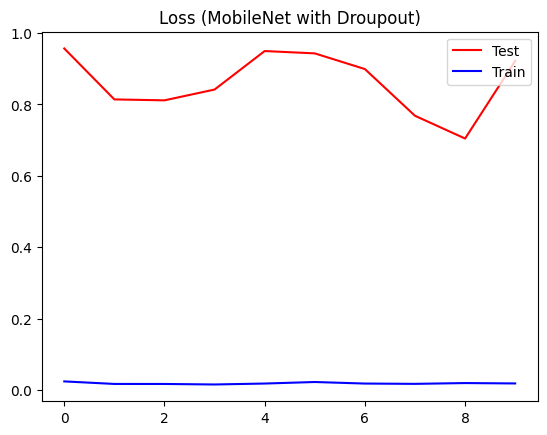

In [40]:
y = np.arange(epochs)

plt.plot(y, test_loss, c='r')
plt.plot(y, train_loss, c='b')
plt.title("Loss (MobileNet with Droupout)")
plt.legend(["Test", "Train"], loc="upper right")

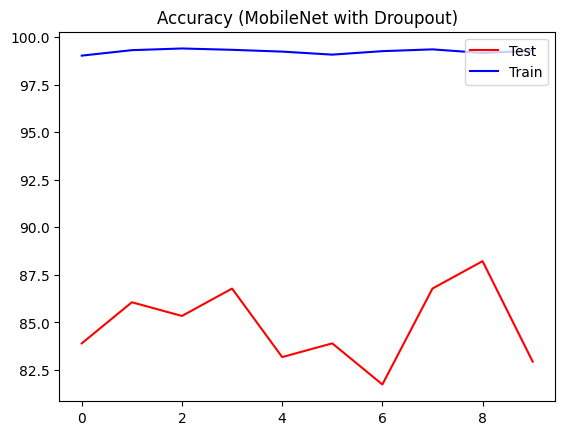

In [41]:
y = np.arange(epochs)

plt.plot(y, test_acc, c='r')
plt.plot(y, train_acc, c='b')
plt.title("Accuracy (MobileNet with Droupout)")
plt.legend(["Test", "Train"], loc="upper right")

In [17]:
def eval_model(model: nn.Module, data: Dataset, ncols, nrows):
    plt.figure(figsize=(15, 15))
    n= ncols*nrows
    for i in range(n):
        classes = data.classes
        rand_int = torch.randint(0, len(data), size=(1,)).item()
        X, y = data[rand_int]
        X_permute = X.permute(1, 2, 0)
        
        device = next(model.parameters()).device

        X, y = X.to(device), y

        model.eval()
        with torch.inference_mode():
            # X.to("cuda")
            # # print(X.device)
            # y_logit = (model(X.unsqueeze(0)))
            # y_pred = torch.round(torch.sigmoid(y_logit))
            y_logit = model(X.unsqueeze(0))
            y_pred =  torch.round(torch.sigmoid(y_logit))

        y_pred = y_pred.type(torch.int).item()
        y_pred = classes[y_pred]
        y_actual = classes[y]

        # plt.figure(figsize=(3, 3))
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(X_permute)
        plt.axis("off")

        if y_pred == y_actual:
            plt.title(f"True: {y_actual} | Pred: {y_pred}", fontsize=10, c="g")
        else:
            plt.title(f"True: {y_actual} | Pred: {y_pred}", fontsize=10, c="r")

In [18]:
rand_tens = torch.randn(size=(1, 3, 224, 224)).to(device)
rand_tens.shape

torch.Size([1, 3, 224, 224])

In [19]:
model(rand_tens)

tensor([[-1.6891]], device='cuda:0', grad_fn=<AddmmBackward0>)

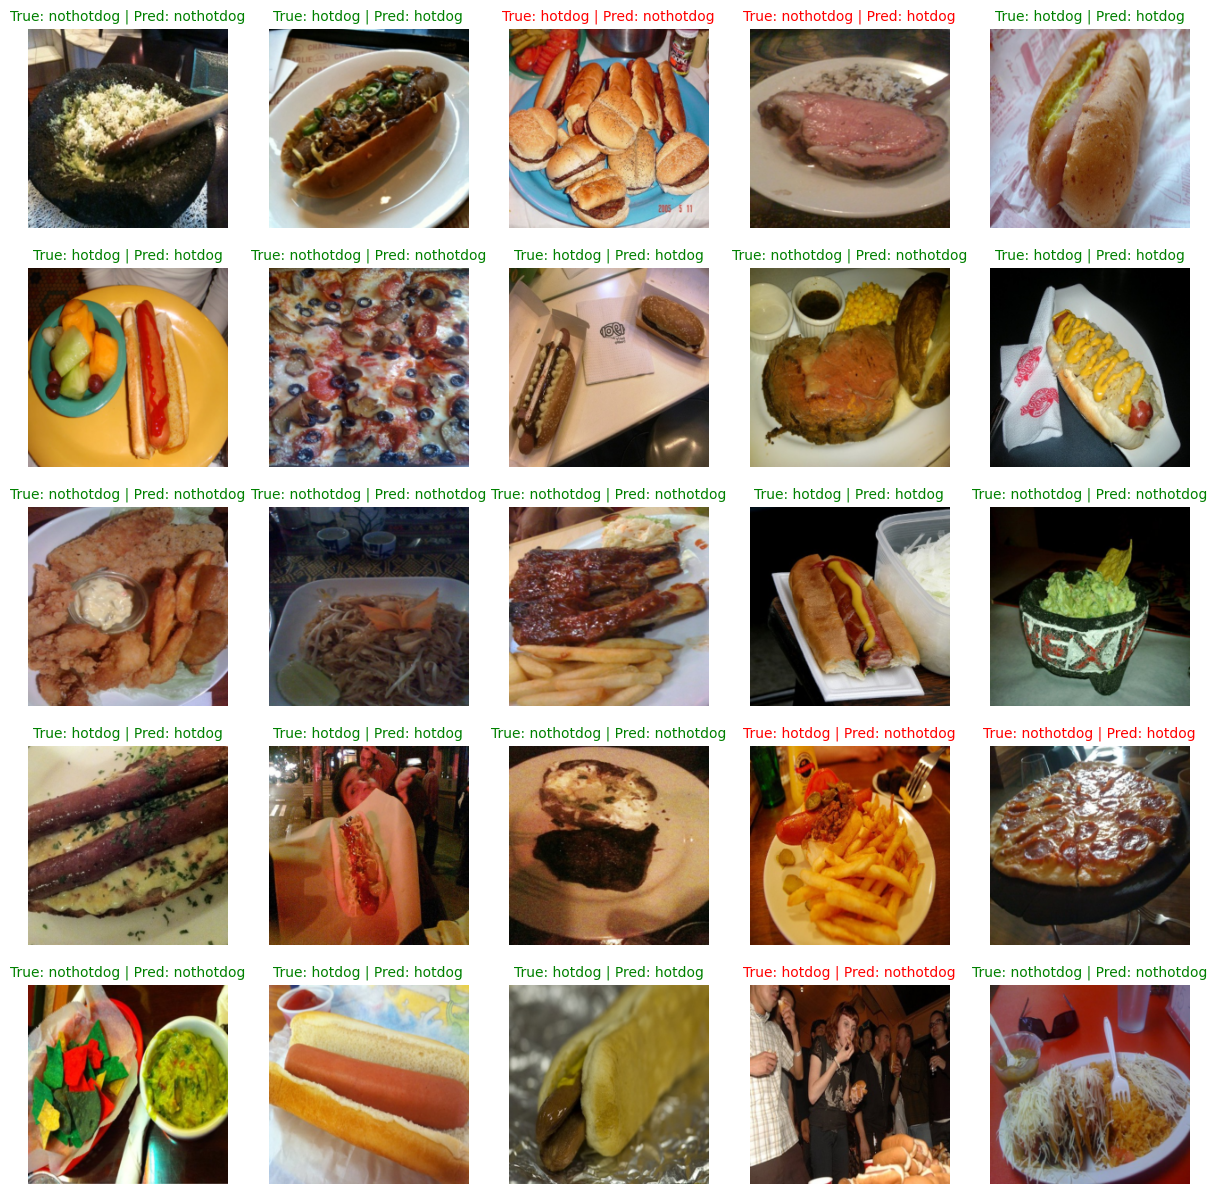

In [37]:
eval_model(model, test_data, 5, 5)

In [22]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "hotdog_nothotdog_Final.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Sve the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\hotdog_nothotdog_Final.pth


In [27]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "hotdog_nothotdog_model_withdropout.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model, MODEL_SAVE_PATH)

Saving model to: models\hotdog_nothotdog_model_withdropout.pth
